# Attribute

**Direct Reference** PINN Repository from Jay Roxis

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Additional Dervative work**: Ben Moseley, PINNs: an introductory crash course

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

# Libraries and Dependencies

In [1]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import warnings
import time
from scipy.integrate import odeint

warnings.filterwarnings('ignore')

**Check device availability**

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Class for generating dense deep network architecture

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.ReLU
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

### Physics Informed Neural Network Class

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, t_data, t_physics, X, N, layers):
        
        # data
        self.X = torch.tensor(X, requires_grad=True).float().to(device)
        self.I, self.D = self.X
        self.t_data = torch.tensor(t_data, requires_grad=True).float().to(device)
        self.t_physics = torch.tensor(t_physics, requires_grad=True).float().to(device)
        self.N = N
        
        # initialize unkown model parameter(s)
        self.beta_param = torch.nn.Parameter(torch.rand(1, requires_grad=True).to(device))
        self.gamma_param = torch.nn.Parameter(torch.rand(1, requires_grad=True).to(device))
        self.mu_param = torch.nn.Parameter(torch.rand(1, requires_grad=True).to(device))
        
        #optional compartment IC
        self.R_init = torch.tensor([[0.]], requires_grad=True).float().to(device)
        self.t_init = torch.tensor([[0.]], requires_grad=True).float().to(device)
        self.S_init = torch.tensor([[(59e6 - 1)/(59e6)]], requires_grad=True).float().to(device)

        #Global scaling params
        self.res_comp_scale = 1.0
        self.res_pop_scale = 1.0
        self.data_scale= 1.0

        # deep neural network
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('gamma', self.gamma_param)
        self.dnn.register_parameter('beta', self.beta_param)
        self.dnn.register_parameter('mu', self.mu_param)

        # store separate losses for visualization (per epoch)
        self.losses = []
        self.datalosses = []
        self.residlosses = []
        self.Nlosses = []
        self.ICLosses = []
        self.betas = [] #track progress of 'beta'
        self.gammas = [] #track progress of 'gamma'
        self.mus = [] #track progress of 'mu'

        l_r = 1e-5
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = l_r)
        self.iter = 0
        self.adam_schedule = torch.optim.lr_scheduler.CyclicLR(self.optimizer_Adam, base_lr=1e-5, \
            max_lr=5e-3, step_size_up=100, mode="exp_range", gamma=0.85, cycle_momentum=False)
        
    #force parameters to be in a range (within -1, 1)
    @property
    def beta(self):
        return abs(torch.tanh(self.beta_param))

    @property
    def gamma(self):
        return abs(torch.tanh(self.gamma_param))

    @property
    def mu(self):
        return abs(torch.tanh(self.mu_param))
    
    def net_x(self, t):  
        out = self.dnn(t)
        S = torch.reshape(out[:,0], (len(t), 1))
        I = torch.reshape(out[:,1], (len(t), 1))
        D = torch.reshape(out[:,2], (len(t), 1))
        R = torch.reshape(out[:,3], (len(t), 1))
        return S, I, D, R
    
    def net_f(self, t):
        """ The pytorch autograd version of calculating residual """       
        snet, inet, dnet, rnet = self.net_x(t)
        snet_t = torch.autograd.grad(
            snet, t, 
            grad_outputs=torch.ones_like(snet),
            create_graph=True,
        )[0]
        inet_t = torch.autograd.grad(
            inet, t, 
            grad_outputs=torch.ones_like(inet),
            create_graph=True,
        )[0]
        dnet_t = torch.autograd.grad(
            dnet, t, 
            grad_outputs=torch.ones_like(dnet),
            create_graph=True,
        )[0]
        rnet_t = torch.autograd.grad(
            rnet, t, 
            grad_outputs=torch.ones_like(rnet),
            create_graph=True,
        )[0]

        s_res = snet_t + (self.beta / self.N)*snet*inet
        i_res = inet_t -  (self.beta / self.N)*snet*inet + self.gamma*inet + self.mu*inet
        d_res = dnet_t - self.mu*inet
        r_res = rnet_t - self.gamma*inet
        N_res = self.N - snet - inet - dnet - rnet
        return s_res, i_res, d_res, r_res, N_res
    
    
    def train(self, nIter, res_comp_scale, res_pop_scale, data_scale):
        self.dnn.train()        
        for epoch in range(nIter+1):
            s_pred, i_pred, d_pred, r_pred = self.net_x(self.t_data) #data
            s_init, i_init, d_init, r_init = self.net_x(self.t_init) #Initial conditions from network
            s_res_pred, i_res_pred, d_res_pred, r_res_pred, N_res_pred = self.net_f(self.t_physics) #physics

            loss_data =  (torch.mean(torch.square(self.I - i_pred)) +
                        torch.mean(torch.square(self.D - d_pred)))
            loss_resid = (torch.mean(torch.square(s_res_pred)) +
                        torch.mean(torch.square(i_res_pred)) + 
                        torch.mean(torch.square(d_res_pred)) +
                        torch.mean(torch.square(r_res_pred)))
            loss_N =  torch.mean(torch.square(N_res_pred))
            loss_init = (torch.mean(torch.square(r_init - self.R_init)) +
                        torch.mean(torch.square(s_init - self.S_init)))
            loss = res_comp_scale*loss_resid + data_scale*loss_data + res_pop_scale*loss_N + loss_init

            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            self.adam_schedule.step()
            self.betas.append(self.beta.item())
            self.gammas.append(self.gamma.item())
            self.mus.append(self.mu.item())

            if epoch % 100 == 0:
                self.losses.append(loss.item())
                self.residlosses.append(res_comp_scale*loss_resid.item())
                self.datalosses.append(data_scale*loss_data.item())
                self.Nlosses.append(res_pop_scale*loss_N.item())
                self.ICLosses.append(loss_init.item())
                print(
                    'It: %d, Loss: %.5f, beta: %.5f, gamma: %.3f, mu: %.3f ' % 
                    (
                        epoch, 
                        loss.item(),
                        self.beta.item(),
                        self.gamma.item(),
                        self.mu.item()
                    )
                )
                
    def predict(self, t):
        self.dnn.eval()
        #net_x is 'predicted' based off of what is given
        s, i, d, r = self.net_x(t)
        s = s.detach().cpu().numpy()
        i = i.detach().cpu().numpy()
        d = d.detach().cpu().numpy()
        r = r.detach().cpu().numpy()
        
        return s, i, d, r

### Generate the differentiations of the compartments

In [5]:
def compartmentaldiff(y, t, beta, gamma, mu):
    S, I, D, R = y
    Sdot = - (beta / N) * S * I
    Idot = (beta / N) * S * I - gamma * I - mu * I
    Rdot = gamma * I
    Ddot = mu * I

    return Sdot, Idot, Ddot, Rdot

### Synthetic Data

In [6]:
# Initial conditions
Ntrue = 59e6 #true population size
N = 1.0 #population size squished into 1 for ease of training
S0 = (Ntrue - 1)/Ntrue
I0 = N - S0
R0 = 0
D0 = 0
y0 = S0, I0, D0, R0

# A grid of time points (in days)
timesteps = 500
duration = 500
t = np.linspace(0, duration, timesteps) #from day 0 to day 500, generate 500 points

# compartmental model parameters
beta = 0.191
gamma = 0.05
mu = 0.0294

# Integrate the SIRD equations over the time grid, t.
ret = odeint(compartmentaldiff, y0, t, args=(beta, gamma, mu))
S, I, D, R = ret.T
S = np.reshape(S, (len(t), 1))
I = np.reshape(I, (len(t), 1))
D = np.reshape(D, (len(t), 1))
R = np.reshape(R, (len(t), 1))

# keep clean data
Sc = S
Ic = I
Dc = D
Rc = R

#reshape time vector
t_data = np.transpose(t)
t_data = np.reshape(t_data, (len(t),1))

#relative noise
noise = 0.05
S = (1 + noise * np.random.normal(0,1, S.shape)) * S
I = (1 + noise * np.random.normal(0,1, I.shape)) * I
D = (1 + noise * np.random.normal(0,1, D.shape)) * D
R = (1 + noise * np.random.normal(0,1, R.shape)) * R

# package all noisy data
Y = S, I, D, R
# choose to include only I and D
X = I, D

### Voluntarily Sparsify Data

In [7]:
#sparsify time and x outputs
sparse_count = 50
t_train = 170
steps = 170
combined_exact_data = np.hstack((t_data[0:t_train], S[0:t_train], I[0:t_train], D[0:t_train], R[0:t_train])) #artificially cutoff time domain early
idxsparse = np.random.choice(range(steps), sparse_count, replace = False)
idxsparse = np.sort(idxsparse)
sparse_exact = combined_exact_data[idxsparse, :]
t_data_sparse = sparse_exact[:,0:1]
S_sparse, I_sparse, D_sparse, R_sparse = sparse_exact[:,1:2], sparse_exact[:,2:3], sparse_exact[:,3:4], sparse_exact[:,4:5] 
Y_sparse = I_sparse, D_sparse

### Plot Synthetic Data

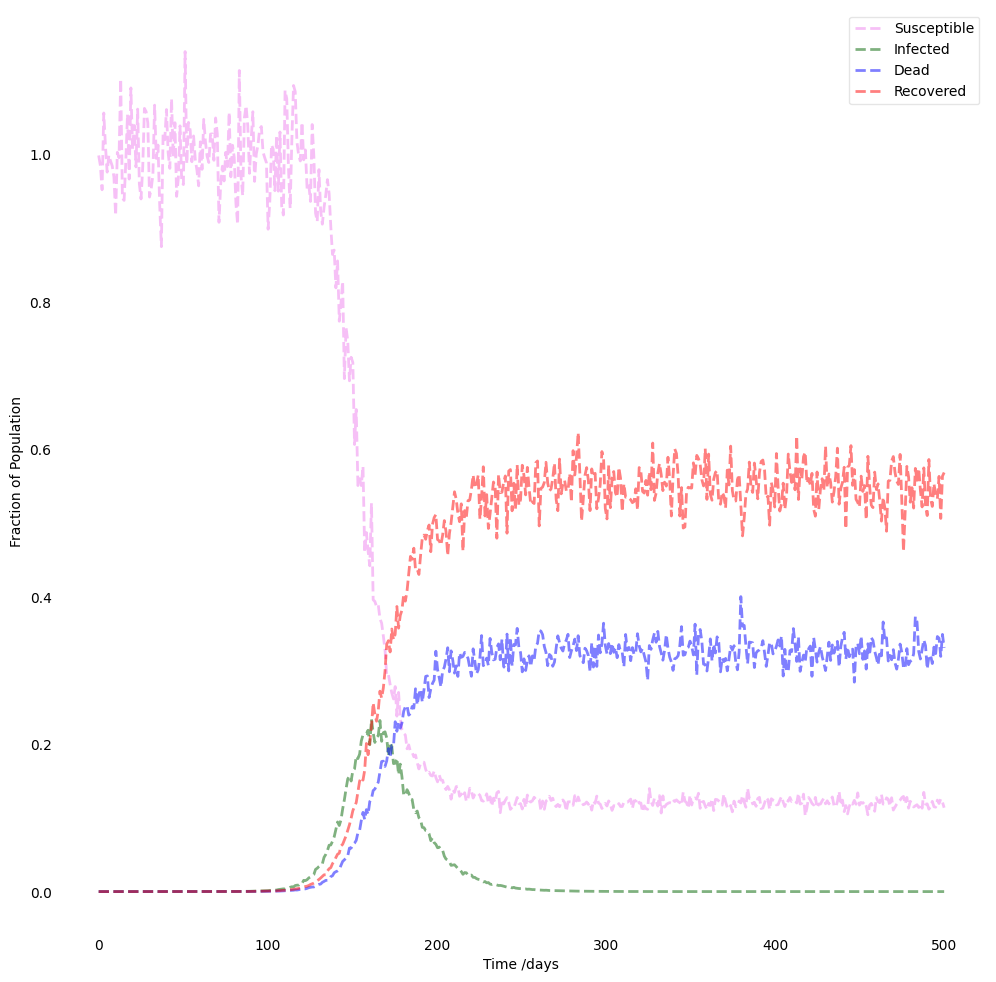

In [8]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='Susceptible', linestyle='dashed')
ax.plot(t, I, 'darkgreen', alpha=0.5, lw=2, label='Infected', linestyle='dashed')
ax.plot(t, D, 'blue', alpha=0.5, lw=2, label='Dead', linestyle='dashed')
ax.plot(t, R, 'red', alpha=0.5, lw=2, label='Recovered', linestyle='dashed')

ax.set_xlabel('Time /days')
ax.set_ylabel('Fraction of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

### Training

In [10]:
# network configuration
layers = [1, 20, 20, 20, 20, 20, 20, 20, 4]
# line up physics mesh to align with baseline
timesteps_phys = 1000
t_phys = np.linspace(0,duration,timesteps_phys)
t_phys = np.transpose(t_phys)
t_phys = np.reshape(t_phys, (len(t_phys),1))
model = PhysicsInformedNN(t_data_sparse, t_phys, Y_sparse, N, layers)

#check number of params
total_params = sum(p.numel() for p in model.dnn.parameters())
print(total_params)
# training inputs: epochs, compartment residual scaling, pop conservation scaling, data scaling
model.train(120000, 10.0, 0.01, 1.0)

2647
It: 0, Loss: 5.96592, beta: 0.07510, gamma: 0.581, mu: 0.373 


KeyboardInterrupt: 

#### Split data and physics training

In [ ]:
#network config
# network configuration
layers = [1, 20, 20, 20, 20, 20, 20, 20, 4]
# line up physics mesh to align with baseline
timesteps_phys = 1000
t_phys = np.linspace(0,duration,timesteps_phys)
t_phys = np.transpose(t_phys)
t_phys = np.reshape(t_phys, (len(t_phys),1))
model = PhysicsInformedNN(t_data_sparse, t_phys, X_sparse, N, layers)

In [ ]:
model.train(15000, 100.0, 0.0001, .001)

### Results Visualizations

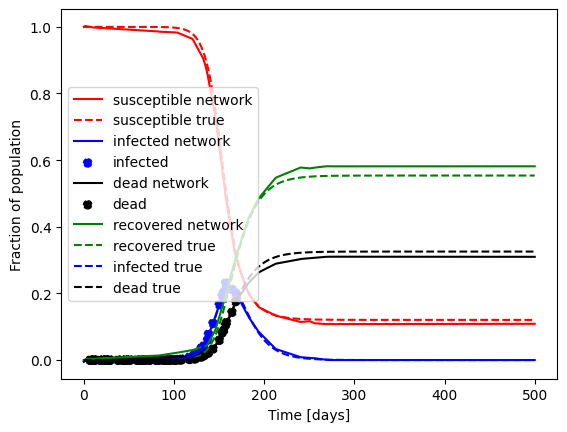

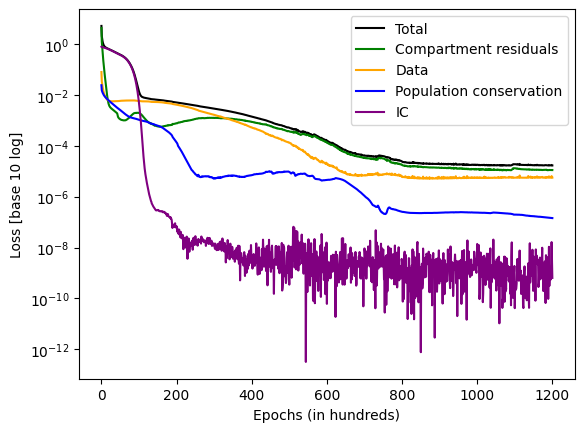

Adam final losses
Loss:  1.7125e-05, Residuals loss: 1.1313e-05, Data loss: 5.6660e-06, Pop Conservation loss: 1.4545e-07, IC Loss: 6.4344e-10
Estimated beta value
0.19082561135292053
Estimated gamma value
0.04920488968491554
Estimated mu value
0.02774265594780445


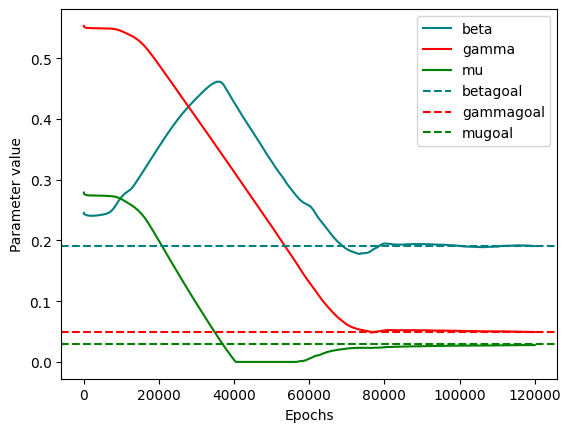

In [ ]:
#plot true result comparison to network output
t_inter = np.linspace(0,duration,500)
t_inter = np.transpose(t_inter)
t_inter = np.reshape(t_inter, (len(t_inter),1))
ttensor = torch.tensor(t_inter).float().to(device)
[snet, inet, dnet, rnet] = model.predict(ttensor)
plt.plot(t_inter, snet, color = 'red', label = 'susceptible network')
plt.plot(t_data, Sc, color = 'red', label = 'susceptible true', linestyle = 'dashed')
plt.plot(t_inter, inet, color = 'blue', label = 'infected network')
plt.scatter(t_data_sparse, I_sparse, color = 'blue', label = 'infected', linestyle = 'dashed')
plt.plot(t_inter, dnet, color = 'black', label = 'dead network')
plt.scatter(t_data_sparse, D_sparse, color = 'black', label = 'dead', linestyle = 'dashed')
plt.plot(t_inter, rnet, color = 'green', label = 'recovered network')
plt.plot(t_data, Rc, color = 'green', label = 'recovered true', linestyle = 'dashed')

plt.plot(t_data, Ic, color = 'blue', label = 'infected true', linestyle = 'dashed')
plt.plot(t_data, Dc, color = 'black', label = 'dead true', linestyle = 'dashed')

plt.legend()
#plt.title('Network recreation of training dataset')
plt.xlabel('Time [days]')
plt.ylabel('Fraction of population')
plt.show()

#Plot Noisy Loss (ADAM)
plt.plot(model.losses[0:],color = 'black', label = "Total")
plt.plot(model.residlosses[0:],color = 'green', label = "Compartment residuals")
plt.plot(model.datalosses[0:],color = 'orange', label = "Data")
plt.plot(model.Nlosses[0:], color = 'blue', label = "Population conservation")
plt.plot(model.ICLosses[0:], color = 'purple', label = "IC")
plt.legend()
plt.yscale("log")
#plt.title("Loss trends under ADAM optimization")
plt.xlabel('Epochs (in hundreds)')
plt.ylabel('Loss [base 10 log]')
plt.show()

# Print final loss components
print('Adam final losses')
print('Loss:  %.4e, Residuals loss: %.4e, Data loss: %.4e, Pop Conservation loss: %.4e, IC Loss: %.4e' % 
        (
            model.losses[-1],
            model.residlosses[-1],
            model.datalosses[-1],
            model.Nlosses[-1],
            model.ICLosses[-1]
        )
    )

print('Estimated beta value')
print(model.beta.item())

print('Estimated gamma value')
print(model.gamma.item())

print('Estimated mu value')
print(model.mu.item())

# plot the learned SIRD parameters vs true SIRD parameters
plt.plot(model.betas[0:], color = 'teal', label ="beta")
plt.plot(model.gammas[0:], color = 'red', label="gamma")
plt.plot(model.mus[0:], color = 'green', label="mu")
plt.axhline(y = 0.191, color = 'teal', linestyle = 'dashed', label ="betagoal")
plt.axhline(y = 0.05, color = 'red', linestyle = 'dashed', label ="gammagoal")
plt.axhline(y = 0.0294, color = 'green', linestyle = 'dashed', label ="mugoal")
plt.legend()
#plt.title('Change in Parameter estimation')
plt.xlabel('Epochs')
plt.ylabel('Parameter value')
plt.show()
